# Image Classification with **_Logistic Regression_** & **_Linear Discriminant Analysis_**

The data we will be working with are the [male](https://course-resources.minerva.kgi.edu/uploaded_files/mke/nA93zn/male-clothing.zip) and [female](https://course-resources.minerva.kgi.edu/uploaded_files/mke/VL14ar/female-clothing.zip) clothing images, which we will use to build a model to classify any given image of a piece of clothing as male or female.

## Preparing the data

In [1]:
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import GridSearchCV

In [2]:
folder_men = "C:\\Users\\breedoon\\Downloads\\Man's Clothing - n03746330\\"
folder_women = "C:\\Users\\breedoon\\Downloads\\Woman's Clothing - n04596852\\"
target_im_size = (60, 80)  # smaller size for faster loading


def get_img_datas(folder, im_size=(256, 144)):
    """
    Reads all images found in `folder`, resizes them to fit into `target_im_size`,
    and convert to a normalized (0-1) list of rgb values of length `im_size[0] * im_size[1] * 3`
    i.e., [r00, r01, r02, ... g00, g01, ... b00, ...].
    Note: .png files will also have an vector of alpha values resulting in total length of `im_size[0] * im_size[1] * 4`
    """
    return np.array([
        (np.array(Image.open(folder + im_file)
                  .resize(im_size)
                  .getdata()) / 255  # convert to floats between 0 and 1
         ).flatten()  # append rgb values next to each other into one big 1-d array
        for im_file in listdir(folder)])


def get_img_from_data(im_data: np.array, im_size=target_im_size) -> Image:
    """
    Returns an image object from the given image data
    :param im_data: a 1d array of unstacked normalized rgb values (returned by `get_img_datas`)
    """
    im = Image.new('RGB', im_size)
    im.putdata(list(map(tuple,  # have to convert to tuples for some reason (otherwise gives an error)
                        (im_data.reshape((-1,  # reshape into 1 by 3 or 4 (rgb or rgba)
                                          len(im_data) // np.multiply(*im_size))) * 255).astype(int))))
    return im



def filled_confusion_matrix(y_true, y_pred, classes=(False, True), normalize=False, add_totals=False):
    """
    Returns a confusion matrix in a format:
           predicted
    actual  F    T
        F  TN   FP
        T  FN   TP: 
    """
    conf_m = confusion_matrix(y_true, y_pred)

    if normalize:
        conf_m = conf_m / conf_m.sum()

    filled_conf_m = pd.DataFrame(conf_m,
                                 index=pd.Series(classes, name='True'),
                                 columns=pd.Series(classes, name='Pred'))
    if add_totals:
        filled_conf_m = filled_conf_m.append(filled_conf_m.sum().rename('Total')).transpose()
        filled_conf_m = filled_conf_m.append(filled_conf_m.sum().rename('Total')).transpose()

    return filled_conf_m

In [3]:
x = np.concatenate([get_img_datas(folder_men, target_im_size),
                    get_img_datas(folder_women, target_im_size)])
y = np.zeros(len(x))
y[len(listdir(folder_men)):] = 1  # mark women as 1  (those indexed after all men images)


seed = 9921
x_train_full, x_test_full, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=seed)

## Classification using full dataset

Since we are equally interested in correctly classifying both kinds of clothes, and our dataset is pretty balanced (1242 versus 1270 images), it is okay for us to use a simple measure of accuracy to assess the performance of the models (while keeping in mind that the accuracy of a random classifier would be 0.5). 

In fact, in this case, accuracy is more preferable than other measures like precision, recall, or F-1 score, since they completely ignore the rate of true negatives (correctly classified male clothes in our case) which might give us a misleading information about the performance of our models. 

Alternatively, we could use (Matthews) correlation coefficient as the more reliable measure of the models' performance, but since our dataset is almost perfectly balanced, its value would be roughly equal to $r = 2a - 1$, where $a$ is the accuracy score, so it would not really tell us anything new, while being less intuitive to interpret than accuracy, so we might as well just stick with accuracy.

In [4]:
Classifier = LogisticRegression
grid_params = dict(
    C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
    max_iter=[10000], # otherwise can fail to converge
)

# grid_search = GridSearchCV(Classifier(), param_grid=grid_params)
# grid_search.fit(x_train_full, y_train)
best_params = dict(C=0.001, max_iter=10000) # grid_search.best_params_

print('Best hyperparameters: ', best_params)

Best hyperparameters:  {'C': 0.001, 'max_iter': 10000}


In [5]:
model = Classifier(**best_params)
model.fit(x_train_full, y_train)

y_pred_train = model.predict(x_train_full)
y_pred = model.predict(x_test_full)
print('Train Accuracy:', accuracy_score(y_train, y_pred_train))
print('Test  Accuracy:', accuracy_score(y_test, y_pred))
print('\nTest Confusion Matrix:')
filled_confusion_matrix(y_test, y_pred, ['Men', 'Women'], True, True).applymap('{:,.1%}'.format)

Train Accuracy: 0.7222498755599801
Test  Accuracy: 0.6858846918489065

Test Confusion Matrix:


Pred,Men,Women,Total
True,,,
Men,32.6%,18.3%,50.9%
Women,13.1%,36.0%,49.1%
Total,45.7%,54.3%,100.0%


As we can see, with full-resolution data, our model a bit better than random guessing on the testing data, having an accuracy of 0.68. The accuracy on the training data is not much better (0.72), which is mostly due to the cross-validation which managed to find the optimal value of the L2 regularization penalty (the C parameter) which made the model more generalizable (as compared to having higher train and lower test accuracy which would be the case with no regularization).

## Classification using PCA

To speed up the computation, we can compress the data using the Principal Component Analysis and use its lower-dimensional representation to build a classifier. The data is already scaled to 0-1 range, which should be sufficient for the PCA to treat all the features equally. 

We can start by initializing PCA with maximum number of components to see if it functions well:

In [6]:
pca = PCA()
pca.fit(x_train_full)

x_train = pca.transform(x_train_full)
x_test = pca.transform(x_test_full)

And we can visualize its first 30 components:

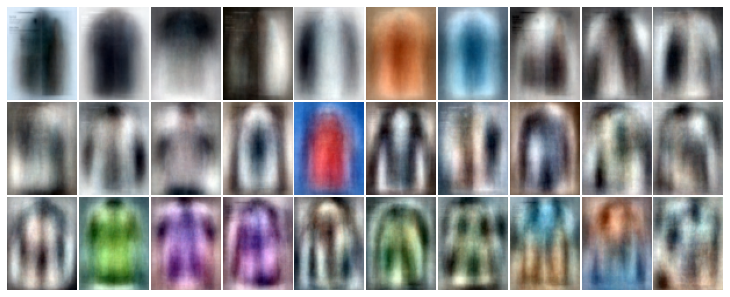

In [7]:
n_components = 30
imgs_per_row = 10
img_scale = 1

imgs = pca.components_[:n_components]
imgs_per_col = len(imgs) // imgs_per_row
figsize = (img_scale * imgs_per_row,
           img_scale * target_im_size[1] / target_im_size[0] * imgs_per_col)
fig, axes = plt.subplots(imgs_per_col, imgs_per_row, figsize=figsize)

for i in range(imgs_per_col):
    for j in range(imgs_per_row):
        axes[i, j].imshow(get_img_from_data(minmax_scale(imgs[i * imgs_per_row + j])))
        axes[i, j].axis('off')

fig.tight_layout(pad=0.2)
plt.show()

As we can see, the components (at least the first few) do seem to be more or less meaningful, differentiating the clothes by their shape, color, etc.

So, if we were to use a lower-dimensional representation of the dataset, we would need to decide on the number of principal components to keep, for which we can try building several models and PCAs with different number of components and measuring their performance:

In [8]:
components_ns = np.unique(np.geomspace(1, min(x_train_full.shape), num=10).astype(int))
y_preds_train = []
y_preds_test = []

for components_n in components_ns:
    pca = PCA(n_components=components_n).fit(x_train_full)

    x_train = pca.transform(x_train_full)
    x_test = pca.transform(x_test_full)

    model = Classifier(**best_params).fit(x_train, y_train)

    y_preds_train.append(model.predict(x_train))
    y_preds_test.append(model.predict(x_test))

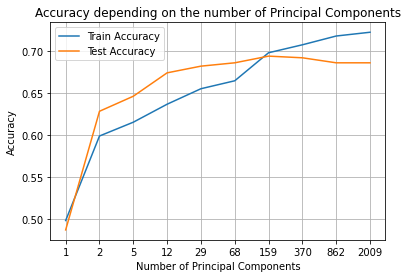

In [9]:
train_scores = np.asarray([accuracy_score(y_train, y_pred) for y_pred in y_preds_train]).T
test_scores = np.asarray([accuracy_score(y_test, y_pred) for y_pred in y_preds_test]).T

ns = list(map(str, components_ns))  # convert to str for equal spacing

plt.plot(ns, train_scores, label='Train Accuracy')
plt.plot(ns, test_scores, label='Test Accuracy')

plt.grid()
plt.legend()
plt.title('Accuracy depending on the number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.show()

As we can see, while the accuracy on the training data keeps increasing as we add more components, the test accuracy plateaus at ~0.68 after the first 159 of them, giving us pretty much the same performance as the model trained on the full dataset, but having only a small fraction of the number of its features.

## Classification using LDA

Similarly, we can use the label-aware LDA to compress our data down to a single feature (since we have only two classes), which, for simplicity, we can scale to a 0-1 range and use as LDA's classification confidence for which we would pick a threshold (which is what any linear classifier would do anyways): 

In [10]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_full, y_train)

# Scale to 0-1 range
x_train_transformed = minmax_scale(lda.transform(x_train_full))
x_test_transformed = minmax_scale(lda.transform(x_test_full))

First we can look at the distribution of classes over the LDA component in test and train data:

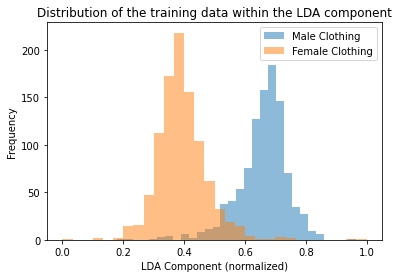

In [11]:
plt.hist(x_train_transformed[y_train.astype(bool)], alpha=0.5, label='Male Clothing', bins=30)
plt.hist(x_train_transformed[~y_train.astype(bool)], alpha=0.5, label='Female Clothing', bins=30)
plt.legend()
plt.xlabel('LDA Component (normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of the training data within the LDA component')
plt.show()

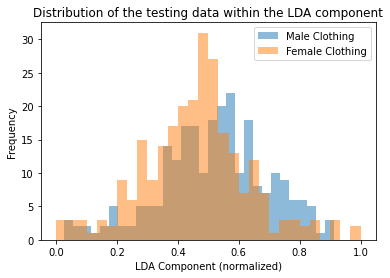

In [12]:
plt.hist(x_test_transformed[y_test.astype(bool)], alpha=0.5, label='Male Clothing', bins=30)
plt.hist(x_test_transformed[~y_test.astype(bool)], alpha=0.5, label='Female Clothing', bins=30)
plt.legend()
plt.xlabel('LDA Component (normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of the testing data within the LDA component')
plt.show()

As we can see, the LDA does a pretty good job separating the two classes in the train data while not doing as good in the test dataset.

To quantify its performance, we can look at LDA's classification scores depending on the threshold on its component.

In [13]:
def get_threshold_scores(y_pred_proba, y_test, scorers=(accuracy_score, precision_score, recall_score, f1_score),
                         min_thr=0, max_thr=1, step=0.1):
    """
    Iterates through all possible thresholds and returns their respective accuracies within the model
    :return:  tuple of (thresholds, scores)
    """
    thresholds = np.arange(min_thr, max_thr + step, step)
    scores = []

    for scorer in scorers:
        scorer_scores = []
        for threshold in thresholds:
            y_pred = y_pred_proba >= threshold
            scorer_scores.append(scorer(y_test, y_pred))
        scores.append(scorer_scores)
    return thresholds, np.array(scores)


def plot_thresholds(y_pred_proba, y_test, scorers=(accuracy_score, precision_score, recall_score, f1_score), **kwargs):
    thresholds, scores = get_threshold_scores(y_pred_proba, y_test, scorers=scorers, **kwargs)
    for i in range(len(scorers)):
        plt.plot(thresholds, scores[i], label=scorers[i].__name__)

    plt.xticks(thresholds)
    plt.yticks(np.linspace(scores.min(), scores.max(), 11))
    plt.grid()

    plt.legend()

    plt.xlabel('Confidence threshold')
    plt.ylabel('Score')

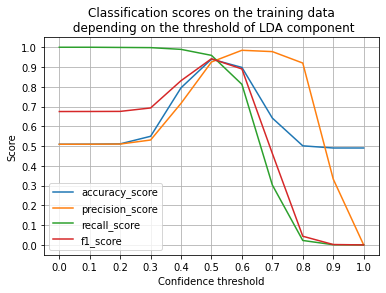

In [14]:
plot_thresholds(x_train_transformed, y_train)
plt.title('Classification scores on the training data\n depending on the threshold of LDA component')
plt.show()

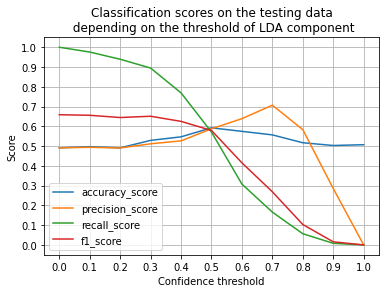

In [15]:
plot_thresholds(x_test_transformed, y_test)
plt.title('Classification scores on the testing data\n depending on the threshold of LDA component')
plt.show()

As expected, on the training data, LDA reaches nearly 95% accuracy at the threshold of 0.5, while on the testing data it barely achieves 60% (also at 0.5), which is hardly better than chance and simply means that LDA was overfit. Additionally, we cannot practically verify that the data (with all its 14400 features) was derived from two multivariate Gaussian distributions (which is the assumption of the LDA), meaning that LDA is not necessarily optimal or appropriate for this task.

## Summary

So, we first used the full-resolution data and were able to achieve the accuracy of 0.68 on the testing data using a cross-validated L2-penalized Logistic Regression. Then, we applied the Principal Component Analysis and achieved roughly the same accuracy with only 1% of the features. Then, we applied LDA and didn't even get 60% accuracy on the training data but did achieve almost 95% accuracy on the testing data.

Going forward, the best choice would be to, first, compress the initial dataset using at most 1000 components, and then apply another (preferably non-linear) classification model like the Support Vector Machines. A non-linear classifier might pick up on the relationships that the logistic regression did not, but with an uncompressed dataset it would take an eternity to cross-validate (given its cubic complexity), so PCA would help bring the cross-validation time down. After that, the model with the best hyperparameters can once again be trained on a full dataset to achieve the highest possible accuracy, or it might still use the compressed dataset without a significant reduction in performance.

Additionally, with enough computational power and patience, the images can also be loaded in their close-to-full resolution resulting in about $300 \cdot 400 \cdot 3 = 360,000$ features. This is unlikely to drastically improve the models' performance but might also result in a slight increase in accuracy.